# Image filtering and finding edges - intelligent Transportation Systems (MTAT.08.040) - Lab 4
Created by Maxime Moreau - contact@maxime-moreau.fr - University of Tartu 2020.

During this lab we will go through image filtering and edges/corners detection using a kernel. This is accomplished by doing a **convolution** between a kernel and an image (matrix format).

## General notes
- [opencv 2dFilter. It's a **correlation** and not a **convolution** by default!](https://docs.opencv.org/4.4.0/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)

The difference between a convolution and a correlation, as I understood, it's the kernel used. That's why sometimes I do `np.flipud(np.fliplr(SOME_KERNEL))`, this is used to do a convolution and not a correlation.

In [1]:
import numpy as np
import cv2
from scipy import signal as sig
from matplotlib import pyplot as plt
from scipy import ndimage as ndi

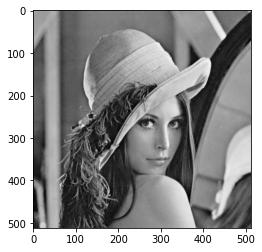

In [2]:
lena = cv2.imread('lena.jpg')
lena = cv2.cvtColor(lena, code=cv2.COLOR_BGR2GRAY)
plt.imshow(lena, cmap='gray')

Explain how do we compute the ROI, why do we use arrange with a pad size which is based on the kernel size.

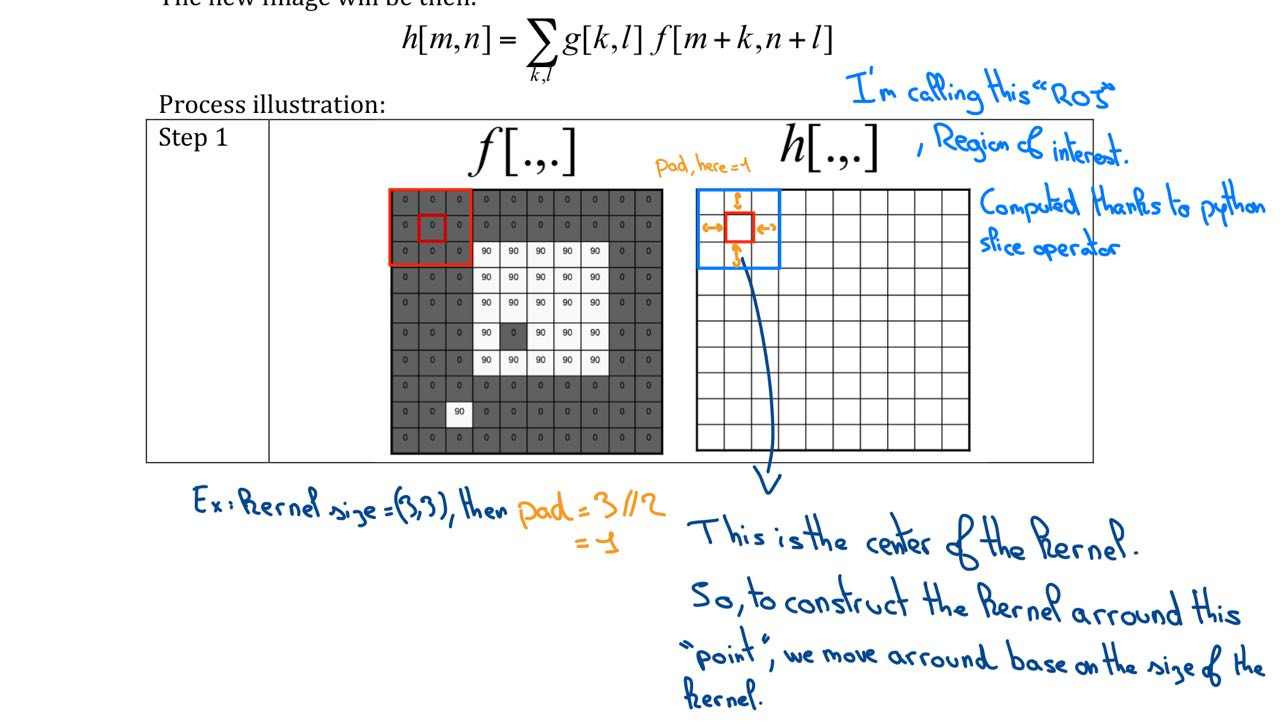

In [3]:
def convolve2D(img, kernel):
    """Performs a naive convolution."""
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]

    pad_y = kernel.shape[0] // 2
    pad_x = kernel.shape[1] // 2
    
#     print(f'we add pad_y={pad_y} and pad_x={pad_x}')

    # Allocate result image.
    pad = ((pad_y, pad_y), (pad_y, pad_x))
    g = np.empty(img.shape, dtype=kernel.dtype)
    img = np.pad(img, pad, mode='constant', constant_values=0)

    # Do convolution
    # we use np.arrange to ignore the padding at the begining of the iteration.
    for y in np.arange(pad_y, img_height+pad_y):
        for x in np.arange(pad_x, img_width+pad_x):
            
            # slice operator is exlusive for the end: [start; end[
            # thas is why we add +1
            roi = img[y - pad_y:y + pad_y + 1, x - pad_x:x + pad_x + 1]

            g[y - pad_y, x - pad_x] = (roi*kernel).sum()

    return g.astype(np.uint8)

## Linear filter

In [17]:
LINEAR = np.array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 0]], dtype=np.uint8)

linear_result = convolve2D(lena, np.flipud(np.fliplr(LINEAR)))
linear_expected = sig.convolve2d(lena, LINEAR, mode="same")
linear_opencv = cv2.filter2D(lena, -1, np.flipud(np.fliplr(LINEAR)), borderType=cv2.BORDER_CONSTANT)

np.testing.assert_equal(linear_result, linear_expected)
np.testing.assert_equal(linear_result, linear_opencv)

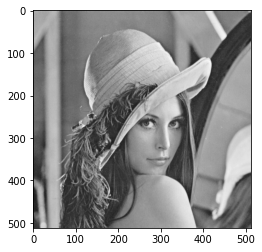

In [5]:
plt.imshow(linear_result, cmap='gray')
plt.show()

## Sharpening filter

In [19]:
SHARPENING_A = np.array([[0, 0, 0],
       [0, 2, 0],
       [0, 0, 0]], dtype=np.uint8)

SHARPENING_B = np.array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=np.uint8)

SHARPENING_B = SHARPENING_B * (1/9)

SHARPENING = SHARPENING_A - SHARPENING_B
print(SHARPENING)

sharp_result = convolve2D(lena, SHARPENING)
sharp_expected = sig.convolve2d(lena, np.flipud(np.fliplr(SHARPENING)), mode="same")
sharp_expected = sharp_expected.astype(np.uint8)

sharp_result

[[-0.11111111 -0.11111111 -0.11111111]
 [-0.11111111  1.88888889 -0.11111111]
 [-0.11111111 -0.11111111 -0.11111111]]


array([[250, 216, 217, ..., 227, 207, 190],
       [216, 162, 162, ..., 176, 162, 165],
       [215, 161, 162, ..., 172, 160, 160],
       ...,
       [ 58,  35,  58, ..., 102,  98, 132],
       [ 57,  35,  65, ..., 105, 107, 142],
       [ 69,  52,  81, ..., 134, 145, 170]], dtype=uint8)

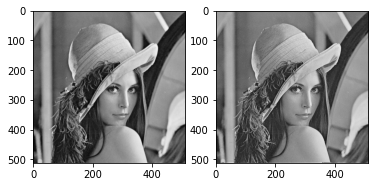

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(lena, cmap='gray')
ax2.imshow(sharp_result, cmap='gray')

## Sobel filter
Note: this is not doing a full Sobel filter, just on one axis. [More information.](https://en.wikipedia.org/wiki/Sobel_operator)

In [8]:
SOBEL = np.array([[1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]], dtype=np.uint8)

sobel_result = convolve2D(lena, SOBEL)
sobel_expected = sig.convolve2d(lena, np.flipud(np.fliplr(SOBEL)), mode="same")

np.testing.assert_equal(sobel_result, sobel_expected)

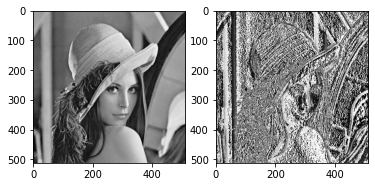

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(lena, cmap='gray')
ax2.imshow(sobel_result, cmap='gray')

## Gaussian filter

In [10]:
GAUSSIAN = np.array([[1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]], dtype=np.uint8)

GAUSSIAN = GAUSSIAN * (1/16)

gaussian_result = convolve2D(lena, GAUSSIAN)
gaussian_expected = sig.convolve2d(lena, np.flipud(np.fliplr(GAUSSIAN)), mode="same")
gaussian_expected = gaussian_expected.astype(np.uint8)

gaussian_cv2 = cv2.filter2D(lena, -1, GAUSSIAN, borderType=cv2.BORDER_CONSTANT)
# this is very close to my result but I think the float to int is not handle like I do.

np.testing.assert_equal(gaussian_result, gaussian_expected)

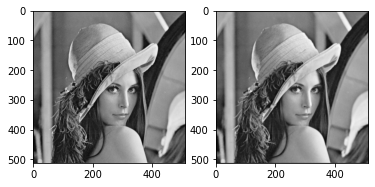

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(lena, cmap='gray')
ax2.imshow(gaussian_result, cmap='gray')

## Haris corner
Sources:
- https://docs.opencv.org/3.4/d4/d7d/tutorial_harris_detector.html
- https://en.wikipedia.org/wiki/Harris_Corner_Detector
- https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345
- https://docs.opencv.org/master/dc/d0d/tutorial_py_features_harris.html

### Step1: load the image as grayscale

In [12]:
chess = cv2.imread('chess.png')
height, width = chess.shape[:2]
chess = cv2.cvtColor(chess, code=cv2.COLOR_BGR2GRAY)

### Step2: Deritative calculation
`I` is the grayscale image in the maths formulas.

We can use the Sobel filter to find the derivatives. Thanks to the Sobel filter we can find the image derivatives in x and y directions by applying two different kernel to the sobel filter.

`I_x` and `I_y` are image derivatives in x and y directions respectively, they are the partial derivatives of `I`.
<math>I_x( x, y)</math> and <math>I_y( x, y)</math>

In [13]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(chess)
I_y = gradient_y(chess)

### Step 3: Structure tensor setup
Now that we have the spatial derivatives, we can construct the structure tensor M.


where M is the structure tensor, we have:
\begin{align*}
M = \underset{(x,y)\in W}\sum 
\begin{bmatrix}
I_x^2 & I_x I_y \\
I_x I_y & I_y^2 
\end{bmatrix}
=
\begin{bmatrix}
\underset{(x,y)\in W}\sum I_x^2 &\underset{(x,y)\in W} \sum I_x I_y \\
\underset{(x,y)\in W}\sum I_x I_y & \underset{(x,y)\in W}\sum I_y^2
\end{bmatrix}
\end{align*}

So we are building this Matrix, which is composed by 3 distincts values: `Ix²` -> `Ixx`, `Ixy` and `Iy²` -> `Iyy`.

In [14]:
Ixx = ndi.gaussian_filter(I_x**2, sigma=1)
Ixy = ndi.gaussian_filter(I_y*I_x, sigma=1)
Iyy = ndi.gaussian_filter(I_y**2, sigma=1)

### Step 4: Harris response calculation

This can be computed by the following formula:
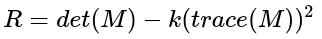

where k is an empirically determined constant
\begin{equation*}
k \in [0.04, 0.06]
\end{equation*}

Small values of k result in detection of sharp corners.

In [15]:
k = 0.05

# determinant of a 2x2 squared matrix: It is the product of the elements on the main diagonal minus the product of the elements off the main diagonal
detA = Ixx * Iyy - Ixy ** 2

# trace
traceA = Ixx + Iyy

harris_response = detA - k * traceA ** 2

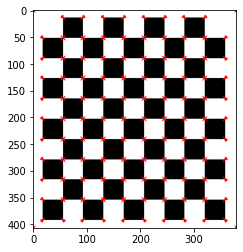

In [16]:
initial = cv2.imread('chess.png')
img_copy_for_corners = np.copy(initial)
img_copy_for_edges = np.copy(initial)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            img_copy_for_edges[rowindex, colindex] = [255,0,0]

plt.imshow(img_copy_for_corners, cmap='gray')